In [41]:
import os 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import graph_ruggedness_de
import gaussian_markov_random_field
import networkx as nx
import matplotlib as mpl
import graph_utils
import scipy.stats as stats
import seaborn as sns

## DMS folding dataset
Compute the Z-scores for DMS folding data (note: kernel dies, run from main using `main_hamming_z_score.py`)

In [2]:
file_list = os.listdir('../data_files/protein_gym/DMS_assays_substitutions/')
file_list = [file for file in file_list if file != '.DS_Store']

file_list.sort()  # Ensure consistent order

likelihood_values = []
files = []
fielder_values = []
norm_factor = []

replicates = 1

landscape_likelihoods = {}

if 'prot_data_checkpoint_hamming.csv' in os.listdir('./'):
    checkpoint_df = pd.read_csv('prot_data_checkpoint.csv', index_col=0)
    parsed_files = checkpoint_df['dataset'].tolist()

else:
    checkpoint_df = pd.DataFrame({
        'dataset': [],
        'z_score': [],
        'log_likelihood': [],
        'fiedler_value': []
    })
    parsed_files = []

for idx, file in enumerate(file_list):        
    try:
        if file.startswith('_'):
            continue
        elif file in parsed_files:
            continue
        # ax_col is an array of two axes: [hist_ax, bar_ax]

        df = pd.read_csv(f'../data_files/protein_gym/DMS_assays_substitutions/{file}')
        df = df.dropna()
        
        # Continue if dataset too large
        if len(df) > 4000:
            continue
        
        seq_ls = df['mutated_sequence'].tolist()
        values = df['DMS_score'].tolist()

        # Build graph and compute metrics
        G_k = graph_ruggedness_de.build_ohe_graph(
            seq_ls=seq_ls,
            values=values,
            edges=False,
        )

        graph_ruggedness_de.add_hamming_edges(G_k, threshold=2)

        comb_laplacian = nx.laplacian_matrix(G_k).asfptype()
        comb_L_dense = comb_laplacian.toarray()
        comb_eigenvalues, _ = np.linalg.eigh(comb_L_dense)
        comb_eigenvalues.sort()
        fielder_value = comb_eigenvalues[1]

        if fielder_value < 1:
            continue
        
        fielder_values.append(fielder_value)


        z_score,log_likelihood = gaussian_markov_random_field.compute_gmrf_ruggedness(G=G_k,
                                                                            t0=30 / fielder_value,
                                                                            standardise=True,
                                                                            samples=10)
        checkpoint_df.loc[idx] = [file, z_score, log_likelihood, fielder_value]

        # Write a checkpoint csv.
        if idx % 2 == 0:
            checkpoint_df.to_csv('prot_data_checkpoint_hamming.csv')
        
        parsed_files.append(file)
        landscape_likelihoods[file] = (z_score, log_likelihood)
    except Exception as e:
        print(f'Error occurred: {str(e)}')


FileNotFoundError: [Errno 2] No such file or directory: 'prot_data_checkpoint.csv'

/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/445563476.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(datasets, rotation=90, fontsize=8)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/445563476.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


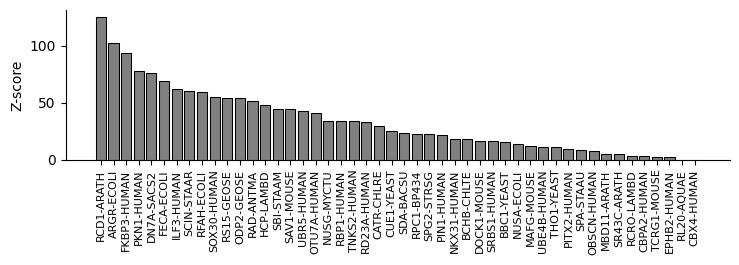

In [16]:
checkpoint_df = pd.read_csv('folding_data_checkpoint_hamming_30_over_t=5.csv')
checkpoint_df["p_value"] = 2 * (1 - stats.norm.cdf(abs(checkpoint_df["z_score"])))
folding_df = checkpoint_df[checkpoint_df['dataset'].str.contains('Tsuboyama', case=False, na=False)]
folding_df = folding_df.sort_values(by='z_score', ascending=False)
datasets = folding_df['dataset'].to_list()
datasets = ['-'.join(dataset.split('_')[0:2]) for dataset in datasets]

fig, ax = plt.subplots(figsize=(7.5, 2.75), constrained_layout=True)
ax.bar(x=datasets, height=folding_df['z_score'], color='grey', edgecolor='black', linewidth=0.75)
ax.set_xticklabels(datasets, rotation=90, fontsize=8)
ax.set_ylabel('Z-score')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('../figures/figure_4/panel_a.pdf')
plt.show()

### Rugged example: ARGR_ECOLI_Tsuboyama_2023_1AOY.csv

Added 12675 Hamming edges.


/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/601370730.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/601370730.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


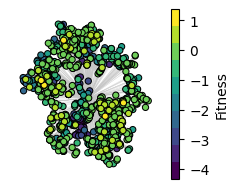

In [37]:
dat = pd.read_csv('../data_files/protein_gym/DMS_assays_substitutions/ARGR_ECOLI_Tsuboyama_2023_1AOY.csv')
wt_mut = dat.iloc[0,0]
wt_seq = dat.iloc[0,1]
wt_list =list(wt_seq)
wt_list[int(wt_mut[1:-1])-1] = wt_mut[0]
wt_seq = ''.join(wt_list)

seq_ls = dat['mutated_sequence'].to_list()
seq_ls.append(wt_seq)

values = dat['DMS_score'].to_list()
values.append(0)

G_k = graph_ruggedness_de.build_ohe_graph(
    seq_ls=seq_ls,
    values=values,
    edges=False,
)

graph_ruggedness_de.add_hamming_edges(G_k, threshold=1) 

values = [node[1]['value'] for node in G_k.nodes(data=True)]
viridis = plt.cm.get_cmap('viridis', 10)

pos = nx.spring_layout(G=G_k, k=0.0001)

nodes_sorted_by_value = sorted(G_k.nodes(data=True), key=lambda x: x[1]['value'])
node_colors = [viridis((node[1]['value'] - min(values)) / (max(values) - min(values))) for node in nodes_sorted_by_value]
nodes_sorted = [node[0] for node in nodes_sorted_by_value]

fig, ax = plt.subplots(figsize=(2.5, 2), constrained_layout=True)
plt.tight_layout()
nx.draw(G_k, pos, nodelist=nodes_sorted, node_color=node_colors, with_labels=False, edgecolors='black', node_size=20, width=0.15, edge_color='#C6C6C6', linewidths=0.75)

sm = mpl.cm.ScalarMappable(cmap=viridis, norm=plt.Normalize(vmin=min(values), vmax=max(values)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Fitness')

plt.tight_layout()
#plt.savefig('../figures/figure_4/panel_b.pdf')

/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/4237434046.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm, label='variance')


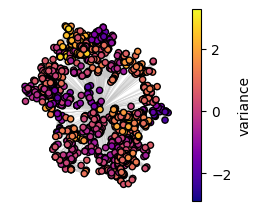

In [38]:
#Fit variance
sigma_squared = np.var(values, ddof=1)
#Timestep = 10
t0 = 5

#Generate sample under heat diffusion model and Gaussian Markov random field.
h0_variance = gaussian_markov_random_field.generate_sample_H0(G=G_k,
                                                            sigma_squared=sigma_squared,
                                                            t=t0)



fig, ax = plt.subplots(figsize=(2.5, 2), constrained_layout=True)

norm0, cmap0 = graph_utils.visualize_signal_over_graph(G=G_k, pos=pos, signal=h0_variance, ax=ax, nodesize=20, edgewidth=0.15, cmap='plasma')
sm = plt.cm.ScalarMappable(cmap=cmap0, norm=norm0)
sm.set_array([]) 
fig.colorbar(sm, label='variance')
#plt.savefig('../figures/figure_4/panel_c.pdf', bbox_inches='tight')
plt.show()


In [40]:
#Graph `G0` with signal defined by the 2nd Laplacian Eigenvector.

signal = np.array([G_k.nodes[node]['value'] for node in G_k.nodes()])
sigma_squared = np.var(signal, ddof=1)

h0_likelihoods = []
h0_log_dets = []
h0_quadratic_forms = []

num_samples = 10

# List to store likelihoods
h0_likelihoods = []

for _ in range(num_samples):
    # Generate a sample under H0
    h0_sample = gaussian_markov_random_field.generate_sample_H0(
        G=G_k,
        t=t0,
        sigma_squared=sigma_squared
    )

    G_cpy = G_k.copy()
    for i, node in enumerate(G_cpy.nodes()):
        G_cpy.nodes[node]['value'] = h0_sample[i]
    
    # Compute the log-likelihood under H0
    h0_likelihood, h0_log_det, h0_quadratic_form = gaussian_markov_random_field.compute_gmrf_ruggedness(G=G_cpy,
                                                                                                        t0=t0)
    h0_likelihoods.append(h0_likelihood)
    h0_log_dets.append(h0_log_det)
    h0_quadratic_forms.append(h0_quadratic_form)


h0_likelihood_empirical, h0_log_det_empirical, h0_quadratic_form_empirical = gaussian_markov_random_field.compute_gmrf_ruggedness(G=G_k,
                                                                                                                                  t0=t0)

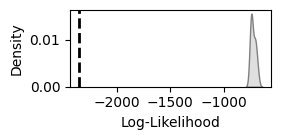

In [42]:
# Plot H0 Likelihood Distribution
plt.figure(figsize=(3, 1.5))
sns.kdeplot(h0_likelihoods, color='grey', fill=True)
plt.axvline(h0_likelihood_empirical, color='black', linestyle='dashed', linewidth=2)

plt.xlabel('Log-Likelihood')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig('../figures/figure_4/panel_ab_density.pdf')
plt.show()

### Smooth example: CBX4_HUMAN_Tsuboyama_2023_2K28.csv	

Added 32431 Hamming edges.


/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/742091245.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/742091245.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


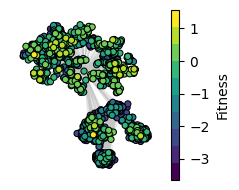

In [43]:
dat = pd.read_csv('../data_files/protein_gym/DMS_assays_substitutions/CBX4_HUMAN_Tsuboyama_2023_2K28.csv')
wt_mut = dat.iloc[0,0]
wt_seq = dat.iloc[0,1]
wt_list =list(wt_seq)
wt_list[int(wt_mut[1:-1])-1] = wt_mut[0]
wt_seq = ''.join(wt_list)

seq_ls = dat['mutated_sequence'].to_list()
seq_ls.append(wt_seq)

values = dat['DMS_score'].to_list()
values.append(0)

G_k = graph_ruggedness_de.build_ohe_graph(
    seq_ls=seq_ls,
    values=values,
    edges=False,
)

graph_ruggedness_de.add_hamming_edges(G_k, threshold=1) 

values = [node[1]['value'] for node in G_k.nodes(data=True)]
viridis = plt.cm.get_cmap('viridis', 10)

pos = nx.spring_layout(G=G_k, k=0.0001)

nodes_sorted_by_value = sorted(G_k.nodes(data=True), key=lambda x: x[1]['value'])
node_colors = [viridis((node[1]['value'] - min(values)) / (max(values) - min(values))) for node in nodes_sorted_by_value]
nodes_sorted = [node[0] for node in nodes_sorted_by_value]

fig, ax = plt.subplots(figsize=(2.5, 2), constrained_layout=True)
plt.tight_layout()
nx.draw(G_k, pos, nodelist=nodes_sorted, node_color=node_colors, with_labels=False, edgecolors='black', node_size=20, width=0.15, edge_color='#C6C6C6', linewidths=0.75)

sm = mpl.cm.ScalarMappable(cmap=viridis, norm=plt.Normalize(vmin=min(values), vmax=max(values)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Fitness')

plt.tight_layout()
#plt.savefig('../figures/figure_4/panel_d.pdf')

/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/974081021.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm, label='variance')


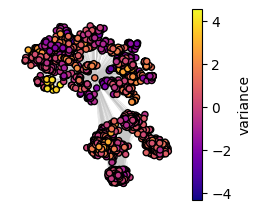

In [44]:
#Fit variance
sigma_squared = np.var(values, ddof=1)
#Timestep = 10
t0 = 5

#Generate sample under heat diffusion model and Gaussian Markov random field.
h0_variance = gaussian_markov_random_field.generate_sample_H0(G=G_k,
                                                            sigma_squared=sigma_squared,
                                                            t=t0)



fig, ax = plt.subplots(figsize=(2.5, 2), constrained_layout=True)

norm0, cmap0 = graph_utils.visualize_signal_over_graph(G=G_k, pos=pos, signal=h0_variance, ax=ax, nodesize=20, edgewidth=0.15, cmap='plasma')
sm = plt.cm.ScalarMappable(cmap=cmap0, norm=norm0)
sm.set_array([]) 
fig.colorbar(sm, label='variance')
#plt.savefig('../figures/figure_4/panel_e.pdf', bbox_inches='tight')
plt.show()


In [45]:
#Graph `G0` with signal defined by the 2nd Laplacian Eigenvector.

signal = np.array([G_k.nodes[node]['value'] for node in G_k.nodes()])
sigma_squared = np.var(signal, ddof=1)

h0_likelihoods = []
h0_log_dets = []
h0_quadratic_forms = []

num_samples = 10

# List to store likelihoods
h0_likelihoods = []

for _ in range(num_samples):
    # Generate a sample under H0
    h0_sample = gaussian_markov_random_field.generate_sample_H0(
        G=G_k,
        t=t0,
        sigma_squared=sigma_squared
    )

    G_cpy = G_k.copy()
    for i, node in enumerate(G_cpy.nodes()):
        G_cpy.nodes[node]['value'] = h0_sample[i]
    
    # Compute the log-likelihood under H0
    h0_likelihood, h0_log_det, h0_quadratic_form = gaussian_markov_random_field.compute_gmrf_ruggedness(G=G_cpy,
                                                                                                        t0=t0)
    h0_likelihoods.append(h0_likelihood)
    h0_log_dets.append(h0_log_det)
    h0_quadratic_forms.append(h0_quadratic_form)


h0_likelihood_empirical, h0_log_det_empirical, h0_quadratic_form_empirical = gaussian_markov_random_field.compute_gmrf_ruggedness(G=G_k,
                                                                                                                                  t0=t0)

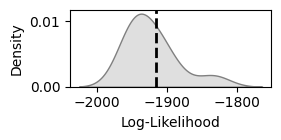

In [46]:
# Plot H0 Likelihood Distribution
plt.figure(figsize=(3, 1.5))
sns.kdeplot(h0_likelihoods, color='grey', fill=True)
plt.axvline(h0_likelihood_empirical, color='black', linestyle='dashed', linewidth=2)

plt.xlabel('Log-Likelihood')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig('../figures/figure_4/panel_de_density.pdf')
plt.show()

## Sparse landscape

In [55]:
file_list = os.listdir('../data_files/sparse_datasets/')
file_list = [file for file in file_list if file != '.DS_Store']

file_list.sort()  # Ensure consistent order

likelihood_values = []
files = []
fielder_values = []
norm_factor = []

replicates = 1

landscape_likelihoods = {}

for idx, file in enumerate(file_list):
    if file.startswith('_'):
        continue
    # ax_col is an array of two axes: [hist_ax, bar_ax]

    df = pd.read_csv(f'../data_files/sparse_datasets/{file}')
    df = df.dropna()
    seq_ls = df['sequence'].tolist()
    values = df['fitness'].tolist()

    # Build graph and compute metrics
    G_k = graph_ruggedness_de.build_ohe_graph(
        seq_ls=seq_ls,
        values=values,
        edges=True,
        hamming_edges=False,
        approximate=True,
        n=int(np.sqrt(len(df)))
    )


    comb_laplacian = nx.laplacian_matrix(G_k).asfptype()
    comb_L_dense = comb_laplacian.toarray()
    comb_eigenvalues, _ = np.linalg.eigh(comb_L_dense)
    comb_eigenvalues.sort()
    fielder_value = comb_eigenvalues[1]

    if fielder_value < 1:
        continue
    
    fielder_values.append(fielder_value)


    likelihood_replicates = []
    for replicate in range(replicates):

        G_sampled = graph_ruggedness_de.sample_graph(G=G_k, sample_size=1)[0]
        graph_ruggedness_de.add_ohe_knn_edges(G_sampled, k=int(np.sqrt(G_sampled.number_of_nodes())))

        z_score, log_likelihood = gaussian_markov_random_field.compute_gmrf_ruggedness(G=G_sampled,
                                                                            t0=30 / fielder_value ,
                                                                            standardise=True,
                                                                            samples=10)
        likelihood_replicates.append(z_score)

    landscape_likelihoods[file] = np.array(likelihood_replicates)


Building approx. NN index.
Done.


Adding OHE vectors to index.: 1130it [00:00, 10239.78it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 1130it [00:00, 36037.38it/s]
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/3520454760.py:36: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()


Computing all vs. all OHE distance matrix.
Done.
Finding K-nearest neighbors.
Done.
Added 21184 KNN edges.
Building approx. NN index.
Done.


Adding OHE vectors to index.: 1110it [00:00, 5563.07it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 1110it [00:00, 37792.35it/s]
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/3520454760.py:36: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()


Computing all vs. all OHE distance matrix.
Done.
Finding K-nearest neighbors.
Done.
Added 18197 KNN edges.
Building approx. NN index.
Done.


Adding OHE vectors to index.: 195it [00:00, 2091.67it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 195it [00:00, 15819.30it/s]

Connecting components



/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/3520454760.py:36: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()


Building approx. NN index.
Done.


Adding OHE vectors to index.: 651it [00:00, 3038.39it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 651it [00:00, 38584.25it/s]
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/3520454760.py:36: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()


Computing all vs. all OHE distance matrix.
Done.
Finding K-nearest neighbors.
Done.
Added 9893 KNN edges.
Building approx. NN index.
Done.


Adding OHE vectors to index.: 224it [00:00, 1349.37it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 224it [00:00, 47496.29it/s]
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/3520454760.py:36: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()


Building approx. NN index.
Done.


Adding OHE vectors to index.: 90it [00:00, 1552.90it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 90it [00:00, 12384.76it/s]
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/3520454760.py:36: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()


Building approx. NN index.
Done.


Adding OHE vectors to index.: 214it [00:00, 1065.26it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 214it [00:00, 40638.43it/s]

Connecting components



/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/3520454760.py:36: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()


/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/3254420606.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Chorismate \n mutates", 'LacI DBD', 'PPAT'], rotation=90, fontsize=8)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/3254420606.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


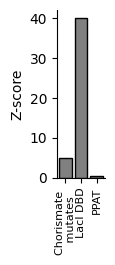

In [62]:
stds = []
means = []
for key in landscape_likelihoods.keys():
    means.append(np.mean(landscape_likelihoods[key]))
    stds.append(np.std(landscape_likelihoods[key]))

fig, ax = plt.subplots(figsize=(1.25, 2.75), constrained_layout=True)
plt.bar(x=["Chorismate \n mutates", 'LacI DBD', 'PPAT'], height=means, color='grey', edgecolor='black')
ax.set_xticklabels(["Chorismate \n mutates", 'LacI DBD', 'PPAT'], rotation=90, fontsize=8)
ax.set_ylabel('Z-score')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('../figures/figure_4/panel_f.pdf')
plt.show()

## Combinatorially complete

In [70]:

file_list = os.listdir('../data_files/combinatorial_complete/')
file_list = [file for file in file_list if file != '.DS_Store']

file_list.sort()  # Ensure consistent order

likelihood_values = []
files = []
fielder_values = []
norm_factor = []

replicates = 1

landscape_likelihoods = {}

checkpoint_df = pd.DataFrame({
    'dataset': [],
    'z_score': [],
    'log_likelihood': [],
    'fiedler_value': []
    })
parsed_files = []

for idx, file in enumerate(file_list):        
    if file.startswith('_'):
        continue
    elif file in parsed_files:
        continue
    # ax_col is an array of two axes: [hist_ax, bar_ax]

    dtype_spec = {'Genotype': str}
    df = pd.read_csv(f'../data_files/combinatorial_complete/{file}', dtype=dtype_spec)
    df = df.dropna()
            
    seq_ls = df['Genotype'].tolist()
    values = df['F'].tolist()

    # Build graph and compute metrics
    G_k = graph_ruggedness_de.build_ohe_graph(
        seq_ls=seq_ls,
        values=values,
        edges=False,
    )

    #Add single mutation edges
    graph_ruggedness_de.add_hamming_edges(G_k, threshold=1)

    comb_laplacian = nx.laplacian_matrix(G_k).asfptype()
    comb_L_dense = comb_laplacian.toarray()
    comb_eigenvalues, _ = np.linalg.eigh(comb_L_dense)
    comb_eigenvalues.sort()
    fielder_value = comb_eigenvalues[1]
    
    fielder_values.append(fielder_value)


    z_score,log_likelihood = gaussian_markov_random_field.compute_gmrf_ruggedness(G=G_k,
                                                                        t0=5,
                                                                        standardise=True,
                                                                        samples=10)
    checkpoint_df.loc[idx] = [file, z_score, log_likelihood, fielder_value]

    
    parsed_files.append(file)
    landscape_likelihoods[file] = (z_score, log_likelihood)

Added 75 Hamming edges.
Added 28 Hamming edges.
Added 28 Hamming edges.
Added 28 Hamming edges.
Added 28 Hamming edges.
Added 28 Hamming edges.
Added 186 Hamming edges.


/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It wil

Added 75 Hamming edges.
Added 75 Hamming edges.
Added 75 Hamming edges.
Added 75 Hamming edges.
Added 75 Hamming edges.


/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It wil

Added 75 Hamming edges.
Added 75 Hamming edges.
Added 75 Hamming edges.


/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()


Added 75 Hamming edges.


/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()


Added 75 Hamming edges.


/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()


Added 75 Hamming edges.


/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()


Added 75 Hamming edges.
Added 441 Hamming edges.


/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()


Added 441 Hamming edges.


/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()


Added 28 Hamming edges.
Added 186 Hamming edges.


/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()


Added 186 Hamming edges.


/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()


Added 28 Hamming edges.
Added 186 Hamming edges.


/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()


Added 186 Hamming edges.


/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()


Added 186 Hamming edges.


/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()


Added 186 Hamming edges.
Added 75 Hamming edges.
Added 28 Hamming edges.


/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()


Added 28 Hamming edges.
Added 28 Hamming edges.
Added 28 Hamming edges.
Added 28 Hamming edges.
Added 28 Hamming edges.
Added 28 Hamming edges.
Added 28 Hamming edges.
Added 28 Hamming edges.
Added 28 Hamming edges.
Added 28 Hamming edges.


/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/1845801333.py:47: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It wil

/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/3549442359.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(datasets, rotation=90, fontsize=8)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/3549442359.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


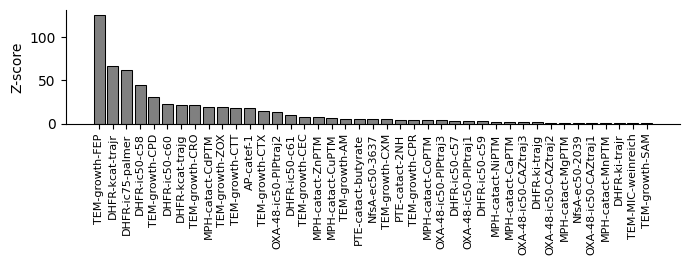

In [78]:
checkpoint_df = checkpoint_df.sort_values(by='z_score', ascending=False)
datasets = checkpoint_df['dataset'].to_list()
datasets = [dataset.strip('.csv').replace('_', '-') for dataset in datasets]

fig, ax = plt.subplots(figsize=(7, 2.75), constrained_layout=True)
ax.bar(x=datasets, height=checkpoint_df['z_score'], color='grey', edgecolor='black', linewidth=0.75)
ax.set_xticklabels(datasets, rotation=90, fontsize=8)
ax.set_ylabel('Z-score')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('../figures/figure_4/panel_g.pdf')
plt.show()

### Rugged example: TEM-growth-FEP

Added 28 Hamming edges.


/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/608961469.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/608961469.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


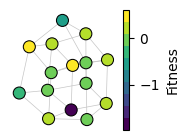

In [175]:
dtype_spec = {'Genotype': str}
    
df = pd.read_csv('../data_files/combinatorial_complete/TEM_growth_FEP.csv', dtype=dtype_spec)
df = df.dropna()
seq_ls = df['Genotype'].tolist()
values = df['F'].tolist()

# Build graph and compute metrics
G_k = graph_ruggedness_de.build_ohe_graph(
    seq_ls=seq_ls,
    values=values,
    edges=False,
)

#Add single mutation edges
graph_ruggedness_de.add_hamming_edges(G_k, threshold=1)

values = [node[1]['value'] for node in G_k.nodes(data=True)]
viridis = plt.cm.get_cmap('viridis', 10)

pos = nx.spring_layout(G=G_k)

nodes_sorted_by_value = sorted(G_k.nodes(data=True), key=lambda x: x[1]['value'])
node_colors = [viridis((node[1]['value'] - min(values)) / (max(values) - min(values))) for node in nodes_sorted_by_value]
nodes_sorted = [node[0] for node in nodes_sorted_by_value]

fig, ax = plt.subplots(figsize=(2, 1.5), constrained_layout=True)
plt.tight_layout()
nx.draw(G_k, pos, nodelist=nodes_sorted, node_color=node_colors, with_labels=False, edgecolors='black', node_size=75, width=0.5, edge_color='#C6C6C6', linewidths=0.75)

sm = mpl.cm.ScalarMappable(cmap=viridis, norm=plt.Normalize(vmin=min(values), vmax=max(values)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Fitness')

plt.tight_layout()
plt.savefig('../figures/figure_4/panel_j.pdf')

/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/710322914.py:4: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/710322914.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm, label='variance')


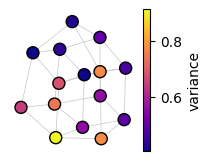

In [176]:
#Fit variance
sigma_squared = np.var(values, ddof=1)

comb_laplacian = nx.laplacian_matrix(G_k).asfptype()
comb_L_dense = comb_laplacian.toarray()
comb_eigenvalues, _ = np.linalg.eigh(comb_L_dense)
comb_eigenvalues.sort()
fielder_value = comb_eigenvalues[1]

t0 = 5

#Generate sample under heat diffusion model and Gaussian Markov random field.
h0_variance = gaussian_markov_random_field.generate_sample_H0(G=G_k,
                                                            sigma_squared=sigma_squared,
                                                            t=t0)



fig, ax = plt.subplots(figsize=(2, 1.5), constrained_layout=True)

norm0, cmap0 = graph_utils.visualize_signal_over_graph(G=G_k, pos=pos, signal=h0_variance, ax=ax, nodesize=75, edgewidth=0.5, cmap='plasma')
sm = plt.cm.ScalarMappable(cmap=cmap0, norm=norm0)
sm.set_array([]) 
fig.colorbar(sm, label='variance')
plt.savefig('../figures/figure_4/panel_k.pdf', bbox_inches='tight')
plt.show()

In [120]:
#Graph `G0` with signal defined by the 2nd Laplacian Eigenvector.

signal = np.array([G_k.nodes[node]['value'] for node in G_k.nodes()])
sigma_squared = np.var(signal, ddof=1)

h0_likelihoods = []
h0_log_dets = []
h0_quadratic_forms = []

num_samples = 10

# List to store likelihoods
h0_likelihoods = []

for _ in range(num_samples):
    # Generate a sample under H0
    h0_sample = gaussian_markov_random_field.generate_sample_H0(
        G=G_k,
        t=t0,
        sigma_squared=sigma_squared
    )

    G_cpy = G_k.copy()
    for i, node in enumerate(G_cpy.nodes()):
        G_cpy.nodes[node]['value'] = h0_sample[i]
    
    # Compute the log-likelihood under H0
    h0_likelihood, h0_log_det, h0_quadratic_form = gaussian_markov_random_field.compute_gmrf_ruggedness(G=G_cpy,
                                                                                                        t0=t0)
    h0_likelihoods.append(h0_likelihood)
    h0_log_dets.append(h0_log_det)
    h0_quadratic_forms.append(h0_quadratic_form)


h0_likelihood_empirical, h0_log_det_empirical, h0_quadratic_form_empirical = gaussian_markov_random_field.compute_gmrf_ruggedness(G=G_k,
                                                                                                                                  t0=t0)

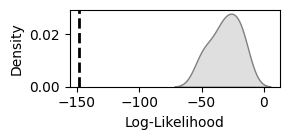

In [121]:
# Plot H0 Likelihood Distribution
plt.figure(figsize=(3, 1.5))
sns.kdeplot(h0_likelihoods, color='grey', fill=True)
plt.axvline(h0_likelihood_empirical, color='black', linestyle='dashed', linewidth=2)

plt.xlabel('Log-Likelihood')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig('../figures/figure_4/panel_jk_density.pdf')
plt.show()

### Smooth example: TEM-growth-SAM

Added 75 Hamming edges.


/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/2167775323.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/2167775323.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


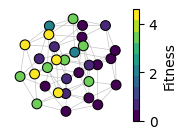

In [184]:
dtype_spec = {'Genotype': str}
    
df = pd.read_csv('../data_files/combinatorial_complete/TEM_MIC_weinreich.csv', dtype=dtype_spec)
df = df.dropna()
seq_ls = df['Genotype'].tolist()
values = df['F'].tolist()

# Build graph and compute metrics
G_k = graph_ruggedness_de.build_ohe_graph(
    seq_ls=seq_ls,
    values=values,
    edges=False,
)

#Add single mutation edges

graph_ruggedness_de.add_hamming_edges(G_k, threshold=1)
values = [node[1]['value'] for node in G_k.nodes(data=True)]
viridis = plt.cm.get_cmap('viridis', 10)

pos = nx.spring_layout(G=G_k)

nodes_sorted_by_value = sorted(G_k.nodes(data=True), key=lambda x: x[1]['value'])
node_colors = [viridis((node[1]['value'] - min(values)) / (max(values) - min(values))) for node in nodes_sorted_by_value]
nodes_sorted = [node[0] for node in nodes_sorted_by_value]

fig, ax = plt.subplots(figsize=(2, 1.5), constrained_layout=True)
plt.tight_layout()
nx.draw(G_k, pos, nodelist=nodes_sorted, node_color=node_colors, with_labels=False, edgecolors='black', node_size=50, width=0.5, edge_color='#C6C6C6', linewidths=0.75)

sm = mpl.cm.ScalarMappable(cmap=viridis, norm=plt.Normalize(vmin=min(values), vmax=max(values)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Fitness')

plt.tight_layout()
plt.savefig('../figures/figure_4/panel_l.pdf')

/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/548131579.py:4: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  comb_laplacian = nx.laplacian_matrix(G_k).asfptype()
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_82759/548131579.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm, label='variance')


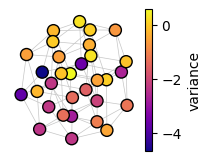

In [187]:
#Fit variance
sigma_squared = np.var(values, ddof=1)

comb_laplacian = nx.laplacian_matrix(G_k).asfptype()
comb_L_dense = comb_laplacian.toarray()
comb_eigenvalues, _ = np.linalg.eigh(comb_L_dense)
comb_eigenvalues.sort()
fielder_value = comb_eigenvalues[1]

t0 = 5

#Generate sample under heat diffusion model and Gaussian Markov random field.
h0_variance = gaussian_markov_random_field.generate_sample_H0(G=G_k,
                                                            sigma_squared=sigma_squared,
                                                            t=t0)



fig, ax = plt.subplots(figsize=(2, 1.5), constrained_layout=True)

norm0, cmap0 = graph_utils.visualize_signal_over_graph(G=G_k, pos=pos, signal=h0_variance, ax=ax, nodesize=75, edgewidth=0.5, cmap='plasma')
sm = plt.cm.ScalarMappable(cmap=cmap0, norm=norm0)
sm.set_array([]) 
fig.colorbar(sm, label='variance')
plt.savefig('../figures/figure_4/panel_m.pdf', bbox_inches='tight')
plt.show()

In [157]:
#Graph `G0` with signal defined by the 2nd Laplacian Eigenvector.

signal = np.array([G_k.nodes[node]['value'] for node in G_k.nodes()])
sigma_squared = np.var(signal, ddof=1)

h0_likelihoods = []
h0_log_dets = []
h0_quadratic_forms = []

num_samples = 10

# List to store likelihoods
h0_likelihoods = []

for _ in range(num_samples):
    # Generate a sample under H0
    h0_sample = gaussian_markov_random_field.generate_sample_H0(
        G=G_k,
        t=t0,
        sigma_squared=sigma_squared
    )

    G_cpy = G_k.copy()
    for i, node in enumerate(G_cpy.nodes()):
        G_cpy.nodes[node]['value'] = h0_sample[i]
    
    # Compute the log-likelihood under H0
    h0_likelihood, h0_log_det, h0_quadratic_form = gaussian_markov_random_field.compute_gmrf_ruggedness(G=G_cpy,
                                                                                                        t0=t0)
    h0_likelihoods.append(h0_likelihood)
    h0_log_dets.append(h0_log_det)
    h0_quadratic_forms.append(h0_quadratic_form)


h0_likelihood_empirical, h0_log_det_empirical, h0_quadratic_form_empirical = gaussian_markov_random_field.compute_gmrf_ruggedness(G=G_k,
                                                                                                                                  t0=t0)

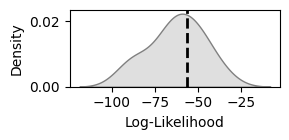

In [158]:
# Plot H0 Likelihood Distribution
plt.figure(figsize=(3, 1.5))
sns.kdeplot(h0_likelihoods, color='grey', fill=True)
plt.axvline(h0_likelihood_empirical, color='black', linestyle='dashed', linewidth=2)

plt.xlabel('Log-Likelihood')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig('../figures/figure_4/panel_lm_density.pdf')
plt.show()